# a run of the full pipeline on our dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 125

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../functions/")

In [5]:
import utils
from analytical import basis_map
from main import predict
from computer_vision import otsu

/home/gvacaliuc/.virtualenvs/ml3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## reading in training data

In [6]:
from utils import DataReader

training_data = DataReader("../data/training/")

ic = training_data.data_ic

In [11]:
metadata, x_train = training_data.get(skip=10)

In [12]:
metadata.head()

,image_id,orig_shape
0,0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e...,"(256, 256)"
1,0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b41...,"(360, 360)"
2,1b2bf5933b0fb82918d278983bee66e9532b53807c3638...,"(256, 256)"
3,1d5f4717e179a03675a5aac3fc1c862fb442ddc3e37392...,"(256, 256)"
4,1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a...,"(360, 360)"


In [13]:
x_train.shape

(67, 128, 128, 3)

In [14]:
y_train = np.stack(training_data.masks)
y_train.shape

(67, 128, 128)

## transforming our basis

In [15]:
from analytical import BasisTransformer

In [16]:
x_train = BasisTransformer().transform(x_train)

## flattening models

In [17]:
from utils import flatten_data

In [18]:
dev_skip = 1

x_dev_flat, y_dev_flat = flatten_data(x_train, y_train, skip=dev_skip)

## model training

In [19]:
from tqdm import tqdm_notebook as tqdm

In [20]:
from sklearn.svm import SVR, SVC
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor

In [56]:
def train_model(estimator, x, y, batch_size = 1000, num_iters = 100):
    
    arange = np.arange(x.shape[0])
    
    for itr in tqdm(range(num_iters)):
        ind = np.random.choice(arange, size = batch_size)
        estimator.partial_fit(x[ind], y[ind])
        
    return estimator

def image_predict(image, model):
    
    num_features = image.shape[-1]
    
    return model.predict(image.reshape((-1, num_features))).reshape(image.shape[:2])

def plot_prediction(model, num):
    
    pred = image_predict(x_train[num], model)

    plt.figure()
    plt.subplot(121)
    plt.imshow(pred)
    plt.subplot(122)
    plt.imshow(y_train[num])

In [57]:
x_dev_flat.shape

(1097728, 9)

In [58]:
sgd_regressor = train_model(
    SGDRegressor(penalty='elasticnet', l1_ratio=0.5),
    x_dev_flat,
    y_dev_flat,
    batch_size = 1000,
    num_iters = 5000)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

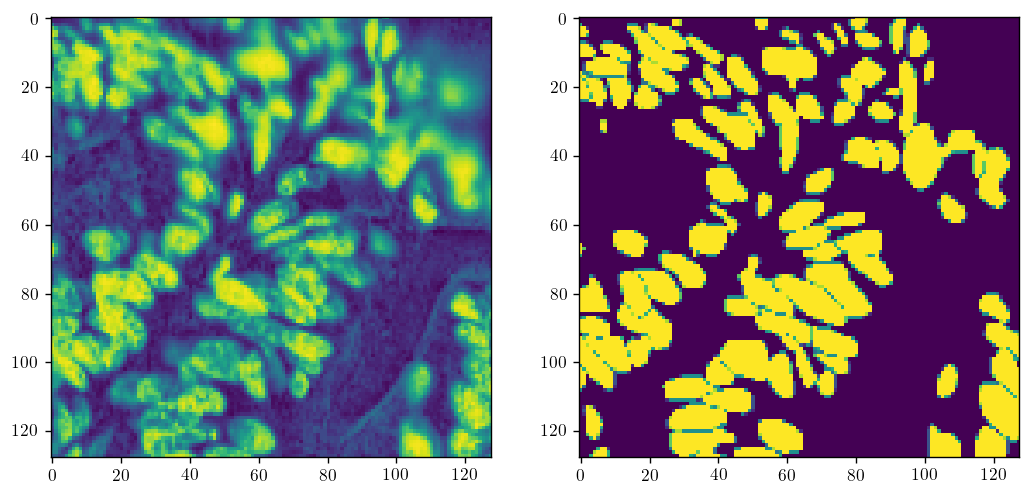

In [64]:
plot_prediction(sgd_regressor, 9)

In [54]:
pa_regressor = train_model(
    PassiveAggressiveRegressor(C = 1.0),
    x_dev_flat,
    y_dev_flat,
    batch_size = 1000,
    num_iters = 5000)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

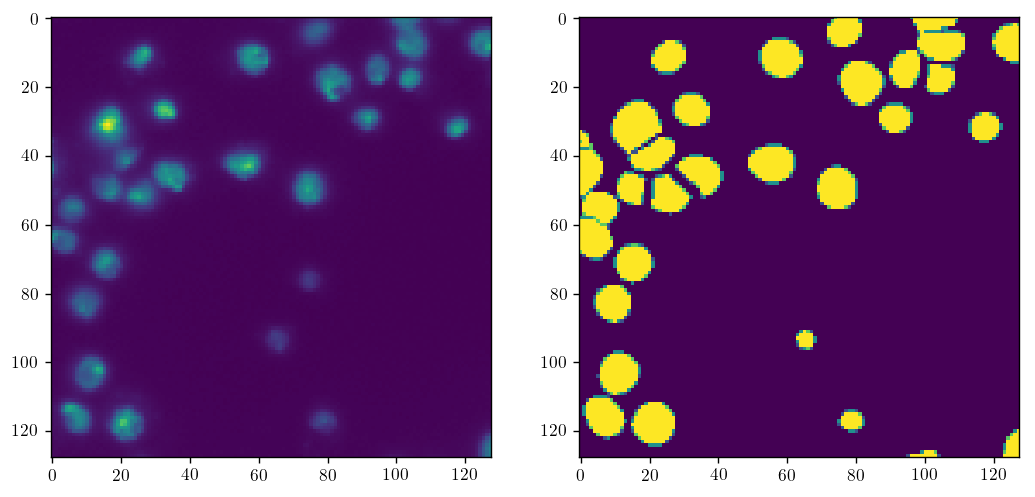

In [55]:
num = 66

pred = image_predict(x_train[num], pa_regressor)

plt.figure()
plt.subplot(121)
plt.imshow(pred)
plt.subplot(122)
plt.imshow(y_train[num])
plt.show()